In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
%pwd

/home/markus/Documents/regression-prediction


'/home/markus/Documents/regression-prediction'

In [3]:
from experiments.modeleval_utils import *
from sklearn.model_selection import cross_validate

/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
def evaluate_pipeline(model, target, data, feature_type, scoring, X_train, y_train, X_test, y_test):
    evaluation = {'model': model}

    pipeline, best_params, best_result = get_pipeline(data, feature_type, target, scoring, model)

    y_test_proportion = len(y_test) / (len(y_train) + len(y_test))
    tscv = TimeSeriesSplit(n_splits=5, test_size=round(len(y_train) * y_test_proportion))
    res = cross_validate(pipeline, X_train, y_train, scoring=['average_precision', 'roc_auc'], cv=tscv, n_jobs=5)
    evaluation['validation'] = res
    
    pipeline.fit(X_train, y_train)
    evaluation['fitted_pipeline'] = pipeline
    evaluation['best_params'] = best_params
    evaluation['best_result'] = best_result

    threshold_train, f1_train = get_best_f1_threshold(pipeline, X_train, y_train)
    threshold_test, f1_test = get_best_f1_threshold(pipeline, X_test, y_test)
    print(f'{threshold_train=} {f1_train=}, {threshold_test=}, {f1_test=}')

    for (split, X_, y_, threshold) in [
        ('train', X_train, y_train, threshold_train),
        ('test', X_test, y_test, threshold_train),
        ('test_pareto', X_test, y_test, threshold_test)
        ]:

        y_score = get_y_score(pipeline, X_)
        y_pred = y_score >= threshold

        evaluation[split] = {
            'average_precision': metrics.average_precision_score(y_, y_score),
            'roc_auc': metrics.roc_auc_score(y_, y_score),

            'threshold': threshold,
            
            'regression': {
                'recall': metrics.recall_score(y_, y_pred, pos_label=1),
                'precision': metrics.precision_score(y_, y_pred, pos_label=1, zero_division=0),
                'f1': metrics.f1_score(y_, y_pred, pos_label=1)
            },
            'non-regression': {
                'recall': metrics.recall_score(y_, y_pred, pos_label=0),
                'precision': metrics.precision_score(y_, y_pred, pos_label=0, zero_division=0),
                'f1': metrics.f1_score(y_, y_pred, pos_label=0)
            },
            'avg_weighted': {
                'recall': metrics.recall_score(y_, y_pred, average='weighted'),
                'precision': metrics.precision_score(y_, y_pred, average='weighted', zero_division=0),
                'f1': metrics.f1_score(y_, y_pred, average='weighted')
            },
            'avg_macro': {
                'recall': metrics.recall_score(y_, y_pred, average='macro'),
                'precision': metrics.precision_score(y_, y_pred, average='macro', zero_division=0),
                'f1': metrics.f1_score(y_, y_pred, average='macro')
            }
        }

    
    return evaluation

def evaluate_pipelines(target, data, feature_type, scoring, X_train, y_train, X_test, y_test):
    evaluations = []
    for model in models:
        print(model)
        try:
            evaluation = evaluate_pipeline(model, target, data, feature_type, scoring, X_train, y_train, X_test, y_test)
            evaluations.append(evaluation)
        except Exception as e:
            print(e)

    return evaluations


In [5]:
def get_overfit_stat_df(evaluation):
    columns = [
        np.array(['train', 'train', 'validation', 'validation', 'test', 'test']),
        np.array(['Avg. Precision', 'AUC', 'Avg. Precision', 'AUC', 'Avg. Precision', 'AUC']),
    ]

    df = pd.DataFrame([[
        evaluation['train']['average_precision'],
        evaluation['train']['roc_auc'],
        evaluation['validation']['test_average_precision'].mean(),
        evaluation['validation']['test_roc_auc'].mean(),
        evaluation['test']['average_precision'],
        evaluation['test']['roc_auc']
        ]],
        index=[model_names[evaluation['model']]],
        columns=columns)
    return df

In [6]:
def get_classification_report_df(evaluation):
    dfs = []
    for split in ['train', 'test', 'test_pareto']:
        df = pd.DataFrame(
            [
                evaluation[split]['regression'],
                evaluation[split]['non-regression'],
                evaluation[split]['avg_macro'],
                evaluation[split]['avg_weighted']
            ],
            index=[
                [model_names[evaluation['model']]]*4,
                ['regression', 'non-regression', 'weighted average', 'micro average']
                ]
        )
        df.columns = [
            np.array([split]*3),
            np.array(['recall', 'precision', 'F1'])
        ]
        dfs.append(df)

    classification_reports = pd.concat(dfs, axis=1)

    return classification_reports

In [ ]:
evaluations_by_config = {}
for (data, target) in [('fixed_defect_szz', 'performance'), ('bugbug_buglevel', 'performance'), ('bugbug_buglevel', 'regression')]:
    for feature_type in ['traditional', 'bow']:
        print('\n\n', '--> ', data, target, feature_type, '\n\n')
        scoring = 'average_precision'

        X, y, features = data_map[feature_type][data](target)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

        evaluations = evaluate_pipelines(target, data, feature_type, scoring, X_train, y_train, X_test, y_test)
        evaluations_by_config[f'{data}_{target}_{feature_type}'] = evaluations

In [ ]:
import pickle
with open('experiments/results/evaluations.pickle', 'wb') as f:
    pickle.dump(evaluations_by_config, f)

In [8]:
import pickle
with  open('experiments/results/evaluations.pickle', 'rb') as f:
    evaluations_by_config = pickle.load(f)

/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [9]:
list(evaluations_by_config.keys())

['fixed_defect_szz_performance_traditional',
 'fixed_defect_szz_performance_bow',
 'bugbug_buglevel_performance_traditional',
 'bugbug_buglevel_performance_bow',
 'bugbug_buglevel_regression_traditional',
 'bugbug_buglevel_regression_bow']

In [45]:
config = 'bugbug_buglevel_performance_traditional'
evaluations = evaluations_by_config[config]

In [46]:
ws = config.split('_')
feature_type = ws.pop()
target = ws.pop()
data = '_'.join(ws)
data, target, feature_type

('bugbug_buglevel', 'performance', 'traditional')

In [47]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [48]:
overfit_stats = pd.concat(
    [get_overfit_stat_df(evaluation) for evaluation in evaluations],
     axis=0)
overfit_stats

train            validation         \
                       Avg. Precision    AUC Avg. Precision    AUC   
Dummy Classifier               0.0268 0.5000         0.0297 0.5000   
Logistic Regression            0.0751 0.6966         0.0767 0.6375   
Support Vector Machine         0.0853 0.7116         0.0804 0.6419   
Random Forest                  0.1844 0.7981         0.1055 0.6804   
XGBoost                        0.6059 0.9208         0.1088 0.6842   
Multi-Layer Perceptron         0.1224 0.7568         0.0870 0.6404   
TPOT                           0.9640 0.9985         0.1163 0.6881   

                                 test         
                       Avg. Precision    AUC  
Dummy Classifier               0.0355 0.5000  
Logistic Regression            0.0929 0.7015  
Support Vector Machine         0.0929 0.6992  
Random Forest                  0.0972 0.6814  
XGBoost                        0.0860 0.6481  
Multi-Layer Perceptron         0.0830 0.6934  
TPOT                           0.1131 0.6875

In [49]:
for c in overfit_stats.columns: #[('test', 'Avg. Precision'), ('test', 'AUC')]:
    amax = overfit_stats.loc[:, c].argmax()
    overfit_stats.loc[overfit_stats.index[amax], c] = f'\\textbf{{{overfit_stats.iloc[amax][c]:.4f}}}'

In [50]:
print(overfit_stats.to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
{} & \multicolumn{2}{l}{train} & \multicolumn{2}{l}{validation} & \multicolumn{2}{l}{test} \\
{} &   Avg. Precision &              AUC &   Avg. Precision &              AUC &   Avg. Precision &              AUC \\
\midrule
Dummy Classifier       &           0.0268 &           0.5000 &           0.0297 &           0.5000 &           0.0355 &           0.5000 \\
Logistic Regression    &           0.0751 &           0.6966 &           0.0767 &           0.6375 &           0.0929 &  \textbf{0.7015} \\
Support Vector Machine &           0.0853 &           0.7116 &           0.0804 &           0.6419 &           0.0929 &           0.6992 \\
Random Forest          &           0.1844 &           0.7981 &           0.1055 &           0.6804 &           0.0972 &           0.6814 \\
XGBoost                &           0.6059 &           0.9208 &           0.1088 &           0.6842 &           0.0860 &           0.6481 \\
Multi-Layer Perceptron &           0.1224 &

/tmp/ipykernel_4257/1422480635.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(overfit_stats.to_latex(escape=False))


In [51]:
classification_reports = pd.concat(
    [get_classification_report_df(evaluation) for evaluation in evaluations],
     axis=0)
classification_reports

train                    test  \
                                        recall precision     F1 recall   
Dummy Classifier       regression       1.0000    0.0268 0.0522 1.0000   
                       non-regression   0.0000    0.0000 0.0000 0.0000   
                       weighted average 0.5000    0.0134 0.0261 0.5000   
                       micro average    0.0268    0.0007 0.0014 0.0355   
Logistic Regression    regression       0.2465    0.0916 0.1336 0.2946   
                       non-regression   0.9326    0.9782 0.9549 0.9109   
                       weighted average 0.5896    0.5349 0.5442 0.6027   
                       micro average    0.9142    0.9545 0.9329 0.8890   
Support Vector Machine regression       0.1916    0.1188 0.1467 0.2199   
                       non-regression   0.9608    0.9773 0.9690 0.9397   
                       weighted average 0.5762    0.5481 0.5578 0.5798   
                       micro average    0.9402    0.9543 0.9470 0.9142   
Random Forest          regression       0.1891    0.2967 0.2310 0.0539   
                       non-regression   0.9876    0.9779 0.9827 0.9873   
                       weighted average 0.5884    0.6373 0.6069 0.5206   
                       micro average    0.9662    0.9596 0.9626 0.9542   
XGBoost                regression       0.4802    0.7560 0.5873 0.0788   
                       non-regression   0.9957    0.9858 0.9908 0.9881   
                       weighted average 0.7380    0.8709 0.7890 0.5335   
                       micro average    0.9819    0.9797 0.9799 0.9558   
Multi-Layer Perceptron regression       0.2245    0.1518 0.1811 0.1618   
                       non-regression   0.9654    0.9783 0.9719 0.9504   
                       weighted average 0.5950    0.5651 0.5765 0.5561   
                       micro average    0.9456    0.9562 0.9507 0.9224   
TPOT                   regression       0.8566    0.9784 0.9135 0.0581   
                       non-regression   0.9995    0.9961 0.9978 0.9979   
                       weighted average 0.9280    0.9872 0.9556 0.5280   
                       micro average    0.9956    0.9956 0.9955 0.9645   

                                                         test_pareto  \
                                        precision     F1      recall   
Dummy Classifier       regression          0.0355 0.0685      1.0000   
                       non-regression      0.0000 0.0000      0.0000   
                       weighted average    0.0177 0.0343      0.5000   
                       micro average       0.0013 0.0024      0.0355   
Logistic Regression    regression          0.1084 0.1585      0.3402   
                       non-regression      0.9723 0.9406      0.8994   
                       weighted average    0.5404 0.5495      0.6198   
                       micro average       0.9417 0.9128      0.8796   
Support Vector Machine regression          0.1183 0.1538      0.2075   
                       non-regression      0.9704 0.9548      0.9531   
                       weighted average    0.5443 0.5543      0.5803   
                       micro average       0.9401 0.9264      0.9267   
Random Forest          regression          0.1354 0.0772      0.4274   
                       non-regression      0.9660 0.9765      0.8393   
                       weighted average    0.5507 0.5268      0.6333   
                       micro average       0.9365 0.9446      0.8247   
XGBoost                regression          0.1959 0.1124      0.2158   
                       non-regression      0.9668 0.9774      0.9475   
                       weighted average    0.5814 0.5449      0.5816   
                       micro average       0.9395 0.9467      0.9215   
Multi-Layer Perceptron regression          0.1071 0.1289      0.2448   
                       non-regression      0.9686 0.9594      0.9327   
                       weighted average    0.5379 0.5442      0.5888   
                    

In [52]:
for c in [('train', 'F1'), ('test', 'F1'), ('test_pareto', 'F1')]:
    reg = classification_reports.loc[pd.IndexSlice[:,'regression', :]]
    amax = reg[c].argmax()
    v = classification_reports.loc[(reg.index[amax], 'regression'), c]
    classification_reports.loc[(reg.index[amax], 'regression'), c] = f'\\textbf{{{v:.4f}}}'

In [53]:
s = classification_reports.to_latex(escape=False)
s = s.replace('Dummy Classifier', '\\multirow{2}{2.7cm}{Dummy\\\\Classifier}')
s = s.replace('\nLogistic Regression', '\\hline\\hline\n\\multirow{2}{2.7cm}{Logistic\\\\Regression}')
s = s.replace('\nSupport Vector Machine', '\\hline\\hline\n\\multirow{2}{2.7cm}{Support Vector\\\\Machine}')
s = s.replace('\nMulti-Layer Perceptron', '\\hline\\hline\n\\multirow{2}{2.7cm}{Multi-Layer\\\\Perceptron}')
s = s.replace('\nRandom Forest', '\\hline\\hline\nRandom Forest')
s = s.replace('\nXGBoost ', '\\hline\\hline\nXGBoost')
s = s.replace('\nTPOT ', '\\hline\\hline\nTPOT')
print(s)

\begin{tabular}{llrrlrrlrrl}
\toprule
     &               & \multicolumn{3}{l}{train} & \multicolumn{3}{l}{test} & \multicolumn{3}{l}{test_pareto} \\
     &               & recall & precision &               F1 & recall & precision &               F1 &      recall & precision &               F1 \\
\midrule
\multirow{2}{2.7cm}{Dummy\\Classifier} & regression & 1.0000 &    0.0268 &           0.0522 & 1.0000 &    0.0355 &           0.0685 &      1.0000 &    0.0355 &           0.0685 \\
     & non-regression & 0.0000 &    0.0000 &           0.0000 & 0.0000 &    0.0000 &           0.0000 &      0.0000 &    0.0000 &           0.0000 \\
     & weighted average & 0.5000 &    0.0134 &           0.0261 & 0.5000 &    0.0177 &           0.0343 &      0.5000 &    0.0177 &           0.0343 \\
     & micro average & 0.0268 &    0.0007 &           0.0014 & 0.0355 &    0.0013 &           0.0024 &      0.0355 &    0.0013 &           0.0024 \\\hline\hline
\multirow{2}{2.7cm}{Logistic\\Regression} & regr

/tmp/ipykernel_4257/4178184239.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  s = classification_reports.to_latex(escape=False)


In [54]:
X, y, features = data_map[feature_type][data](target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

performance: 1880 positive 2.77% - negative 66041 97.23%
X.shape=(67921, 302)



In [55]:
fitted_pipelines = [(model_names[evaluation['model']], evaluation['fitted_pipeline']) for evaluation in evaluations[1:]] # exclude dummy

/home/markus/Documents/regression-prediction/experiments/modeleval_utils.py:160: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * R * P / (R + P)


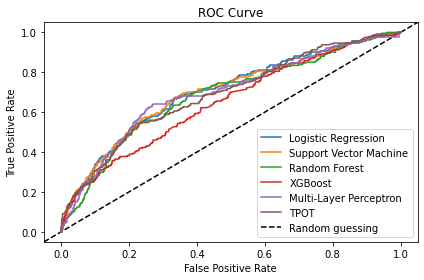

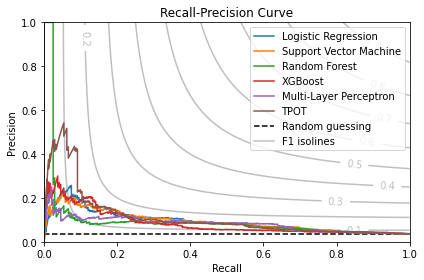

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
 <Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Recall-Precision Curve'}, xlabel='Recall', ylabel='Precision'>)

In [56]:
plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring,
    fitted_pipelines, X_train, X_test, y_train, y_test, save=True, figsize=(6,4), ylim=[0, 0.3 if data == 'fixed_defect_szz' else 1.0])

In [27]:
scoring = 'average_precision'
feature_type = 'traditional'
target = 'performance'
data = 'fixed_defect_szz'

In [26]:
X, y, features = get_ml_data_traditional('fixed_defect_szz', target, kind='commitlevel', drop_columns=lambda columns: [c for c in columns if 'delta_' in c or 'min_' in c or 'max_' in c or 'sum_' in c])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

performance: 589 positive 0.59% - negative 99105 99.41%
X.shape=(99694, 55)



In [15]:
features.columns

Index(['number_of_commits', 'lines_added', 'lines_deleted', 'lines_modified',
       'number_of_modified_files', 'number_of_subsystems',
       'number_of_directories', 'entropy_lines_modified', 'comment_length',
       'developer_age', 'developer_experience', 'recent_developer_experience',
       'backouts_developer', 'recent_backouts_developer',
       'mean_developer_experience_subsystem',
       'mean_recent_developer_experience_subsystem', 'mean_backouts_subsystem',
       'mean_recent_backouts_subsystem', 'mean_developer_experience_directory',
       'mean_recent_developer_experience_directory', 'mean_backouts_directory',
       'mean_recent_backouts_directory', 'mean_file_changes', 'mean_file_ages',
       'mean_file_commits_since_last_change', 'mean_file_number_of_developers',
       'mean_nargs_sum', 'mean_nexits_sum', 'mean_cognitive_sum',
       'mean_cyclomatic_sum', 'mean_cyclomatic_average', 'mean_halstead_n1',
       'mean_halstead_N1', 'mean_halstead_n2', 'mean_halstead

In [28]:
evaluation = evaluate_pipeline('lr', target, data, feature_type, scoring, X_train, y_train, X_test, y_test)

threshold_train=0.008018290199115747 f1_train=0.023065833733781838, threshold_test=0.011296138899245274, f1_test=0.05333333333333334


In [29]:
get_classification_report_df(evaluation)

train                          test  \
                                        recall precision        F1    recall   
Logistic Regression regression        0.253968  0.012082  0.023066  0.318182   
                    non-regression    0.867930  0.994563  0.926941  0.807600   
                    weighted average  0.560949  0.503322  0.475004  0.562891   
                    micro average     0.864050  0.988355  0.921230  0.806520   

                                                         test_pareto  \
                                     precision        F1      recall   
Logistic Regression regression        0.003644  0.007205    0.090909   
                    non-regression    0.998136  0.892815    0.994873   
                    weighted average  0.500890  0.450010    0.542891   
                    micro average     0.995942  0.890861    0.992879   

                                                          
                                     precision        F1  
Logistic Regression regression        0.037736  0.053333  
                    non-regression    0.997983  0.996426  
                    weighted average  0.517860  0.524880  
                    micro average     0.995864  0.994345

In [30]:
pipeline = evaluation['fitted_pipeline']

invalid value encountered in true_divide


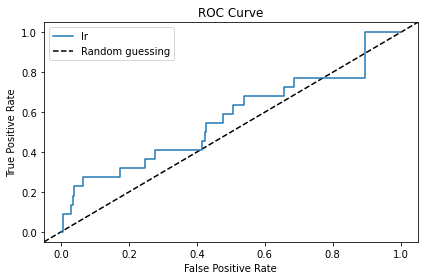

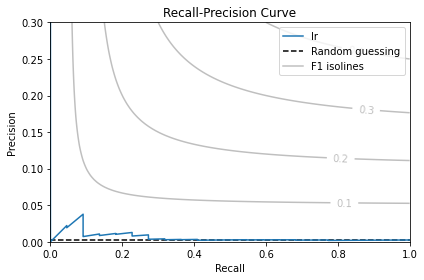

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
 <Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Recall-Precision Curve'}, xlabel='Recall', ylabel='Precision'>)

In [31]:
plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring,
    [('lr', pipeline)], X_train, X_test, y_train, y_test, save=True, figsize=(6,4), ylim=[0, 0.3 if data == 'fixed_defect_szz' else 1.0])

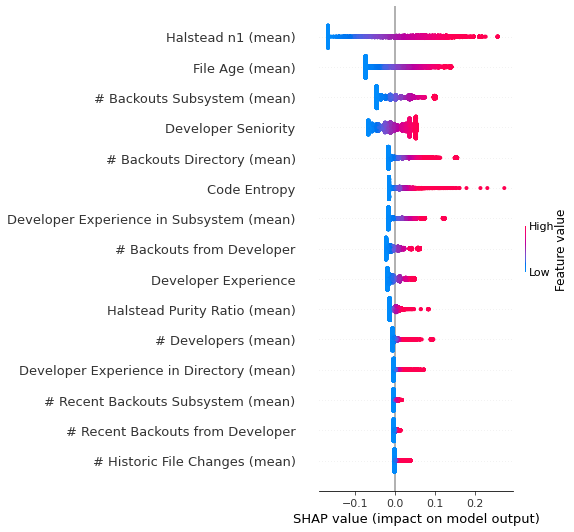

In [32]:
import shap
from feature_name_map import feature_name_map
f = features

kind = 'traditional'
clf = pipeline['model']
if 'traditional' in kind:
    X_ = pipeline['scaler'].transform(X_test)
    f = f.drop('target', axis=1)
    feature_names = [feature_name_map[c] for c in f.columns]
else:
    X_ = X_test.toarray()
    feature_names = f

explainer = shap.Explainer(clf, X_, feature_names=feature_names)
print(explainer)
shap_values = explainer.shap_values(X_)

shap.summary_plot(shap_values, X_, max_display=15, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()